## **Mô hình Softmax Regression**

## **Import các thư viện cần thiết**

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## **Dữ liệu**

In [178]:
df = pd.read_csv("../../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng Softmax Regression**

In [179]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn: chuyển về 0, 1, 2
y = df["NSP"].values - 1 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Thêm bias (1) vào đầu X
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# # Chuyển X thành dạng (d, N)
# X_scaled = X_scaled.T

X = X_scaled

In [180]:
# Số lớp
C = len(np.unique(y))

def convert_labels(y, C=C):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / e_Z.sum(axis=0)

def softmax(Z):
    e_Z = np.exp(Z)
    return e_Z / e_Z.sum(axis=0)

def softmax_regression(X, y, W_init, eta, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 1500
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [181]:
def evaluate_model(W, X_test, y_test):
    y_pred = pred(W, X_test)
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred,zero_division=1)
    cm = confusion_matrix(y_test, y_pred)
    return acc, cr, cm


## **Triển khai Softmax Regression với nhiều tỷ lệ train/validation: 4:1; 7:3; 6:4**

### **Giảm trước chia sau**

In [182]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []

    for train_ratio in train_ratios:
        method = "gốc"
        X_temp = X.copy()
        
        if use_pca:
            method = f"PCA-{n_components}"
            pca = PCA(n_components=n_components)
            X_temp = pca.fit_transform(X_temp)
        elif use_lda:
            method = f"LDA-{n_components}"
            lda = LDA(n_components=n_components)
            X_temp = lda.fit_transform(X_temp, y)

        # Train/Validation split
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y, train_size=train_ratio, stratify=y, random_state=42)

        # Add bias
        X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1).T
        X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1).T

        d = X_train.shape[0]
        C = len(np.unique(y))
        W_init = np.random.randn(d, C)
        
        W = softmax_regression(X_train, y_train, W_init, eta=0.05)

        acc, cr, cm = evaluate_model(W[-1], X_val, y_val)
    
        print("Dữ liệu", method, ":")
        print(f"Tỷ lệ: {int(train_ratio*10)}:{int((1-train_ratio)*10)}")
        print(f"Accuracy: {acc}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{cr}\n")

        results.append({
            'method': method,
            'train_ratio': f"{int(train_ratio*10)}:{int((1-train_ratio)*10)}",
            'acc': acc,
            'cr': cr,
            'cm': cm
        })

    return results


In [183]:
print(X_scaled.shape)  # Kiểm tra kích thước của X
print(y.shape)         # Kiểm tra kích thước của y


(2126, 22)
(2126,)


In [184]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6])

Dữ liệu gốc :
Tỷ lệ: 8:1
Accuracy: 0.8755868544600939
Confusion Matrix:
[[301  29   2]
 [  8  50   1]
 [  2  11  22]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       332
         1.0       0.56      0.85      0.67        59
         2.0       0.88      0.63      0.73        35

    accuracy                           0.88       426
   macro avg       0.80      0.79      0.78       426
weighted avg       0.90      0.88      0.88       426


Dữ liệu gốc :
Tỷ lệ: 7:3
Accuracy: 0.8918495297805643
Confusion Matrix:
[[462  32   3]
 [ 16  71   1]
 [  3  14  36]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       497
         1.0       0.61      0.81      0.69        88
         2.0       0.90      0.68      0.77        53

    accuracy                           0.89       638
   macro avg       0.82      0.81      0.80       638
weighted a

In [185]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: gốc với tỷ lệ huấn luyện 7:3
Accuracy: 0.8918495297805643


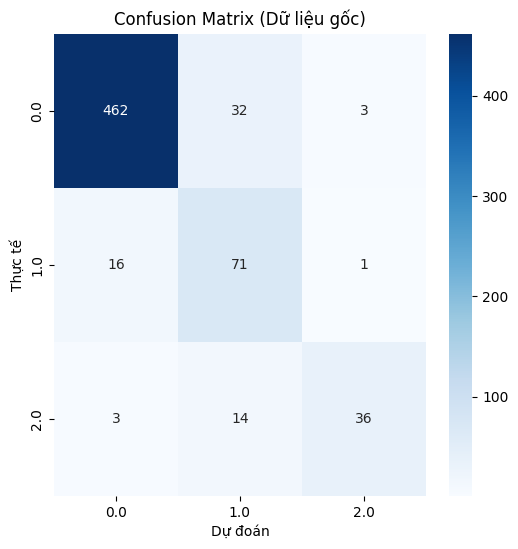

In [186]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (Dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [187]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=12)

Dữ liệu PCA-12 :
Tỷ lệ: 8:1
Accuracy: 0.8544600938967136
Confusion Matrix:
[[316  12   4]
 [ 26  20  13]
 [  3   4  28]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       332
         1.0       0.56      0.34      0.42        59
         2.0       0.62      0.80      0.70        35

    accuracy                           0.85       426
   macro avg       0.70      0.70      0.68       426
weighted avg       0.84      0.85      0.84       426


Dữ liệu PCA-12 :
Tỷ lệ: 7:3
Accuracy: 0.8605015673981191
Confusion Matrix:
[[447  46   4]
 [ 17  68   3]
 [  5  14  34]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93       497
         1.0       0.53      0.77      0.63        88
         2.0       0.83      0.64      0.72        53

    accuracy                           0.86       638
   macro avg       0.77      0.77      0.76       638
weig

In [188]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: PCA-12 với tỷ lệ huấn luyện 6:4
Accuracy: 0.8801410105757932


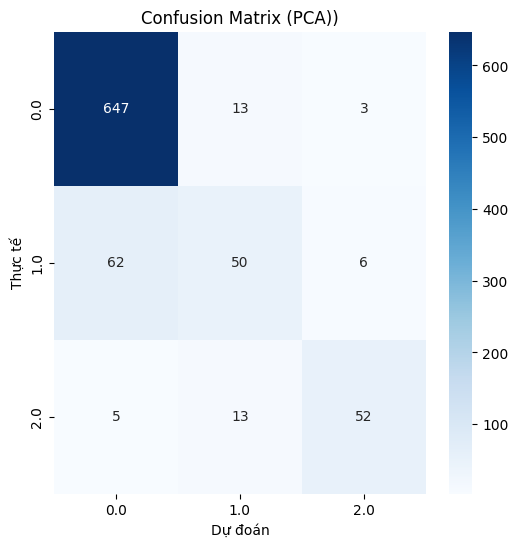

In [189]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA))")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [190]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)

Dữ liệu LDA-2 :
Tỷ lệ: 8:1
Accuracy: 0.8943661971830986
Confusion Matrix:
[[317  13   2]
 [ 13  42   4]
 [  3  10  22]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       332
         1.0       0.65      0.71      0.68        59
         2.0       0.79      0.63      0.70        35

    accuracy                           0.89       426
   macro avg       0.79      0.77      0.78       426
weighted avg       0.90      0.89      0.89       426


Dữ liệu LDA-2 :
Tỷ lệ: 7:3
Accuracy: 0.8808777429467085
Confusion Matrix:
[[463  30   4]
 [ 20  64   4]
 [  5  13  35]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       497
         1.0       0.60      0.73      0.66        88
         2.0       0.81      0.66      0.73        53

    accuracy                           0.88       638
   macro avg       0.79      0.77      0.78       638
weight

In [191]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: LDA-2 với tỷ lệ huấn luyện 8:1
Accuracy: 0.8943661971830986


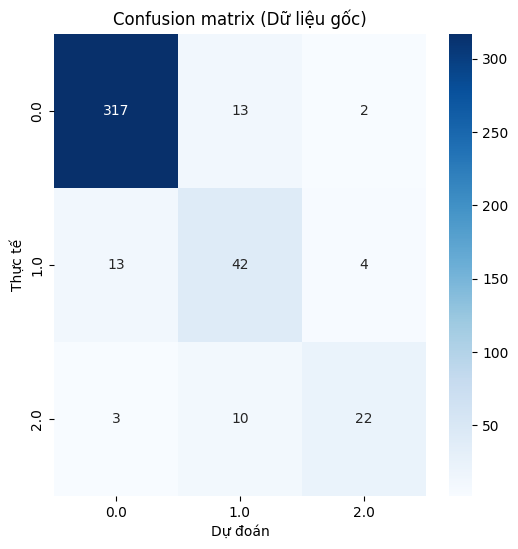

In [192]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion matrix (Dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [193]:
for res in results:
    if res['method'] == 'LDA-2' and res['train_ratio'] == '7:3':
        print("Kết quả LDA-2 với tỉ lệ 7:3")
        # print(f"Accuracy: {res['acc']}")
        # print(f"Confusion Matrix:\n{res['cm']}")
        print(f"Classification Report:\n{res['cr']}\n")
        conf_matrix = res['cm']

Kết quả LDA-2 với tỉ lệ 7:3
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       497
         1.0       0.60      0.73      0.66        88
         2.0       0.81      0.66      0.73        53

    accuracy                           0.88       638
   macro avg       0.79      0.77      0.78       638
weighted avg       0.89      0.88      0.88       638




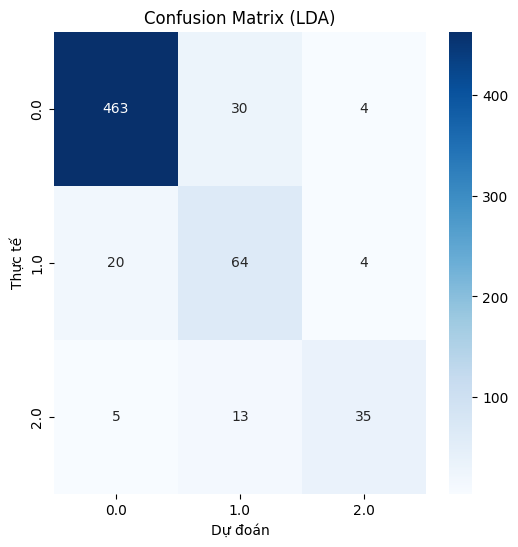

In [194]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
        xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

### **Chia trước giảm sau**

In [195]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []

    for train_ratio in train_ratios:
        method = "gốc"
        
        # Chia dữ liệu train/test trước khi giảm chiều
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=train_ratio, stratify=y, random_state=42)

        # Giảm chiều 
        if use_pca:
            method = f"PCA-{n_components}"
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
        elif use_lda:
            method = f"LDA-{n_components}"
            lda = LDA(n_components=n_components)
            X_train = lda.fit_transform(X_train, y_train)
            X_val = lda.transform(X_val)

        # Thêm bias
        X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1).T
        X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1).T

        d = X_train.shape[0]
        C = len(np.unique(y))
        W_init = np.random.randn(d, C)

        # Huấn luyện mô hình
        W = softmax_regression(X_train, y_train, W_init, eta=0.05)

        # Đánh giá
        acc, cr, cm = evaluate_model(W[-1], X_val, y_val)

        print("Dữ liệu", method, ":")
        print(f"Tỷ lệ: {int(train_ratio*10)}:{int((1-train_ratio)*10)}")
        print(f"Accuracy: {acc}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{cr}\n")

        results.append({
            'method': method,
            'train_ratio': f"{int(train_ratio*10)}:{int((1-train_ratio)*10)}",
            'acc': acc,
            'cr': cr,
            'cm': cm
        })

    return results


#### **Thực hiện trên tập dữ liệu giảm chiều bằng PCA**

In [196]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=12)

Dữ liệu PCA-12 :
Tỷ lệ: 8:1
Accuracy: 0.8685446009389671
Confusion Matrix:
[[323   4   5]
 [ 30  25   4]
 [  2  11  22]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       332
         1.0       0.62      0.42      0.51        59
         2.0       0.71      0.63      0.67        35

    accuracy                           0.87       426
   macro avg       0.75      0.68      0.70       426
weighted avg       0.85      0.87      0.86       426


Dữ liệu PCA-12 :
Tỷ lệ: 7:3
Accuracy: 0.8448275862068966
Confusion Matrix:
[[462  30   5]
 [ 35  49   4]
 [  2  23  28]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       497
         1.0       0.48      0.56      0.52        88
         2.0       0.76      0.53      0.62        53

    accuracy                           0.84       638
   macro avg       0.72      0.67      0.69       638
weig

In [197]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: PCA-12 với tỷ lệ huấn luyện 6:4
Accuracy: 0.882491186839013


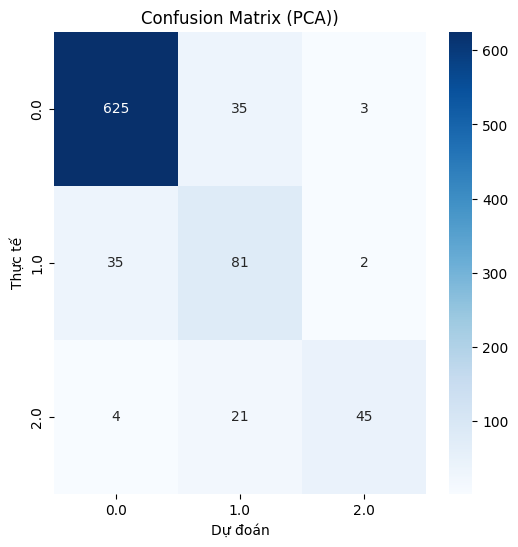

In [198]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA))")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [199]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)

Dữ liệu LDA-2 :
Tỷ lệ: 8:1
Accuracy: 0.8615023474178404
Confusion Matrix:
[[312  16   4]
 [ 17  38   4]
 [  3  15  17]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       332
         1.0       0.55      0.64      0.59        59
         2.0       0.68      0.49      0.57        35

    accuracy                           0.86       426
   macro avg       0.72      0.69      0.70       426
weighted avg       0.86      0.86      0.86       426


Dữ liệu LDA-2 :
Tỷ lệ: 7:3
Accuracy: 0.8871473354231975
Confusion Matrix:
[[473  20   4]
 [ 29  54   5]
 [  5   9  39]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       497
         1.0       0.65      0.61      0.63        88
         2.0       0.81      0.74      0.77        53

    accuracy                           0.89       638
   macro avg       0.80      0.77      0.78       638
weight

In [200]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: LDA-2 với tỷ lệ huấn luyện 7:3
Accuracy: 0.8871473354231975


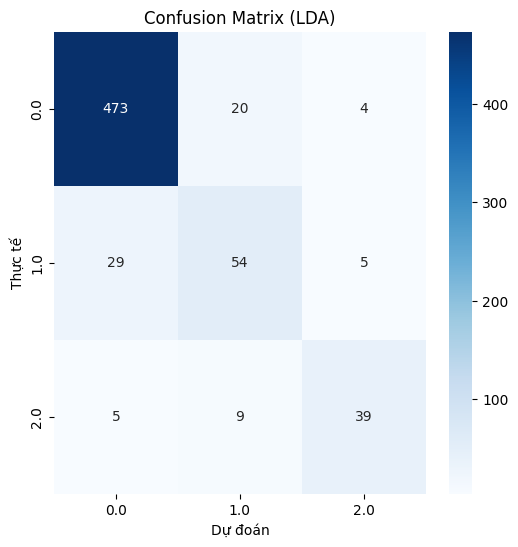

In [201]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()